# **Conditional edges in LangGraph**

In this tutorial we create a graph with two conditional edges to respond to users based off their message either emotionally or logically

In [2]:
!pip install langchain_community langchain_openai langgraph


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.1/151.1 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.7/437.7 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 20.4 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found exi

In [3]:
from typing import Annotated, Literal
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from google.colab import userdata

In [4]:
#Model set up for external model
#llm = init_chat_model(
#    "anthropic:claude-3-5-sonnet-latest"
#)
#Let's use OpenAI
import os
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')


In [5]:
class MessageClassifier(BaseModel):
    message_type: Literal["emotional", "logical"] = Field(
        ...,
        description="Classify if the message requires an emotional (therapist) or logical response."
    )


class State(TypedDict):
    messages: Annotated[list, add_messages]
    message_type: str | None

In [6]:
#selecting the model
llm = ChatOpenAI(model="gpt-3.5-turbo")

In [7]:
#Defining the functions for each node
def classify_message(state: State):
    last_message = state["messages"][-1]
    classifier_llm = llm.with_structured_output(MessageClassifier)

    result = classifier_llm.invoke([
        {
            "role": "system",
            "content": """Classify the user message as either:
            - 'emotional': if it asks for emotional support, therapy, deals with feelings, or personal problems
            - 'logical': if it asks for facts, information, logical analysis, or practical solutions
            """
        },
        {"role": "user", "content": last_message.content}
    ])
    return {"message_type": result.message_type}


def router(state: State):
    message_type = state.get("message_type", "logical")
    if message_type == "emotional":
        return {"next": "therapist"}

    return {"next": "logical"}


def therapist_agent(state: State):
    last_message = state["messages"][-1]

    messages = [
        {"role": "system",
         "content": """You are a compassionate therapist. Focus on the emotional aspects of the user's message.
                        Show empathy, validate their feelings, and help them process their emotions.
                        Ask thoughtful questions to help them explore their feelings more deeply.
                        Avoid giving logical solutions unless explicitly asked."""
         },
        {
            "role": "user",
            "content": last_message.content
        }
    ]
    reply = llm.invoke(messages)
    return {"messages": [{"role": "assistant", "content": reply.content}]}


def logical_agent(state: State):
    last_message = state["messages"][-1]

    messages = [
        {"role": "system",
         "content": """You are a purely logical assistant. Focus only on facts and information.
            Provide clear, concise answers based on logic and evidence.
            Do not address emotions or provide emotional support.
            Be direct and straightforward in your responses."""
         },
        {
            "role": "user",
            "content": last_message.content
        }
    ]
    reply = llm.invoke(messages)
    return {"messages": [{"role": "assistant", "content": reply.content}]}

In [8]:
#Lets build the graph
graph_builder = StateGraph(State)

graph_builder.add_node("classifier", classify_message)
graph_builder.add_node("router", router)
graph_builder.add_node("therapist", therapist_agent)
graph_builder.add_node("logical", logical_agent)

graph_builder.add_edge(START, "classifier")
graph_builder.add_edge("classifier", "router")

graph_builder.add_conditional_edges(
    "router",
    lambda state: state.get("next"),
    {"therapist": "therapist", "logical": "logical"}
)

graph_builder.add_edge("therapist", END)
graph_builder.add_edge("logical", END)

graph = graph_builder.compile()

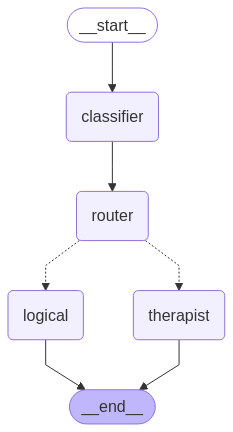

In [11]:
#let's visualize this graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [9]:
from langchain.schema import HumanMessage

# Invoke the graph
state = graph.invoke({"messages": [HumanMessage(content=input("Enter your message: "))]})

# Print the LLM's response
print(state["messages"][-1].content)

Enter your message: i feel sad right now


/usr/local/lib/python3.11/dist-packages/langchain_openai/chat_models/base.py:1643: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


I'm sorry to hear that you're feeling sad. It's completely normal to feel this way at times. Can you tell me more about what's been going on that's making you feel sad right now?


In [10]:
state = graph.invoke({"messages": [HumanMessage(content=input("Enter your message: "))]})

# Print the LLM's response
print(state["messages"][-1].content)

Enter your message: i need a guide to starting a business


/usr/local/lib/python3.11/dist-packages/langchain_openai/chat_models/base.py:1643: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


Starting a business involves several key steps:

1. **Business Idea:** Start by identifying a viable business idea. It should be something you are passionate about and that solves a problem in the market.

2. **Market Research:** Conduct thorough market research to understand your target audience, competition, and industry trends. This will help you refine your business idea and positioning.

3. **Business Plan:** Develop a detailed business plan outlining your business goals, target market, financial projections, marketing strategy, and operational plan.

4. **Legal Structure:** Decide on the legal structure of your business (e.g., sole proprietorship, partnership, LLC) and register your business with the relevant authorities.

5. **Funding:** Determine how you will finance your business. This could be through personal savings, loans, investors, or crowdfunding.

6. **Business Name and Branding:** Choose a memorable business name and create a strong brand identity, including a logo an

In [12]:
messages = [HumanMessage(content="How many times a week should one work out")]
result = graph.invoke({"messages": messages})
result['messages'][-1].content

/usr/local/lib/python3.11/dist-packages/langchain_openai/chat_models/base.py:1643: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


'The American College of Sports Medicine recommends that adults engage in at least 150 minutes of moderate-intensity exercise per week, spread out over several days. This equates to around 30 minutes a day for five days a week. However, the frequency and duration of workouts can vary depending on individual goals, fitness levels, and preferences. It is generally recommended to consult with a healthcare provider or a fitness professional to determine an appropriate workout frequency based on individual needs and circumstances.'